In [1]:
# If using this on Google Colab, we need to install the packages
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Let's install required packages
if IN_COLAB:
    import subprocess
    import sys
    
    packages = ['cudaq', 'dimod', 'scipy', 'networkx', 'matplotlib']
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

In [2]:
# Optional: Configure CUDA-Q simulator settings
# If you encounter GPU-related issues, uncomment the following lines:
import os
import dotenv

# Create or ensure .env exists or set overrides directly:
dotenv.set_key(".env", "CUDAQ_DEFAULT_SIMULATOR", "qpp-cpu")
dotenv.set_key(".env", "CUDA_VISIBLE_DEVICES", "")

dotenv.load_dotenv(".env", override=True)
os.environ["CUDAQ_DEFAULT_SIMULATOR"] = "qpp-cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# Additional package installations for enhanced functionality
# Install additional visualization and quantum tools if needed

import sys

try:
    import matplotlib.pyplot as plt
    # Optional quantum tools
    try:
        import qutip
        import ipywidgets as widgets
    except ImportError:
        print("Optional quantum tools (qutip, ipywidgets) not found.")
        print("These are not required for basic CUDA-Q functionality.")

except ImportError:
    print("Installing required visualization tools...")
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib>=3.5'])
    print("Matplotlib installed. Please restart your kernel if needed.")

In [4]:
# Import necessary packages for QAOA implementation

import networkx as nx
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Optional: Import widgets for interactive elements
try:
    import ipywidgets as widgets
    from ipywidgets import interact
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("ipywidgets not available - interactive features disabled")

print("All required packages imported successfully!")


All required packages imported successfully!


In [5]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5,6, 5])


In [6]:
epsilon = 1
rho = np.sum(np.abs(c)) + epsilon
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
Beta = rho*np.matmul(b.T,b)
print(Q)
print(Beta)

[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


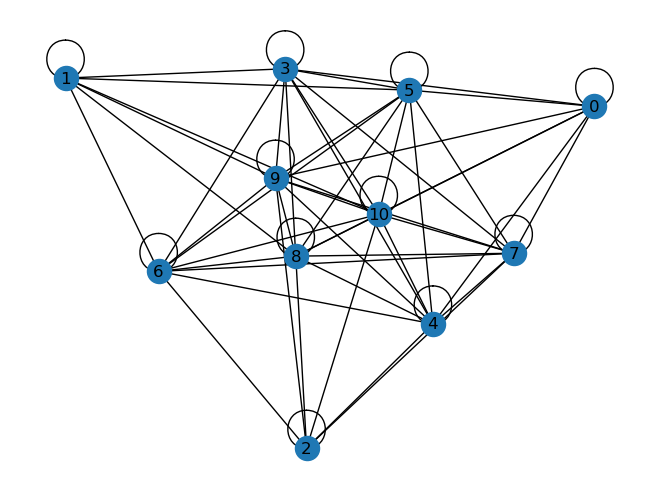

In [8]:
G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)

In [10]:
from itertools import combinations

print(Q)

def qubo_to_ising(Q, tol=1e-12):
    """
    Convert a QUBO matrix to an Ising Hamiltonian
    
    Args:
        Q (np.ndarray): QUBO matrix (nxn)
        tol (float): Cutoff for near zero terms
    
    Returns:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    """
    #TODO Start
    n = Q.shape[0]
    
    # two-body 
    J_pairs, J_coeffs = [], []
    for i, j in combinations(range(n), 2):
        coeff = 0.25 * Q[i, j]
        if abs(coeff) > tol:
            J_pairs.extend([i, j])       
            J_coeffs.append(float(coeff))
    
    # one-body
    h = np.zeros(n, dtype=float)

    # diagonal contributions
    for i in range(n):

        h[i] += -0.5 * Q[i,i]  #diagonal

        for j in range(n):     # linear z_i terms (sum terms in same row)

            if j > i:

                h[i] += -0.25 * Q[i,j]

        for k in range(i):    # linear z_j terms (sum terms in same column)


            if k < i:

                h[i] += -0.25 * Q[k,i]
    
    return h.tolist(), J_pairs, J_coeffs

h_list, pair_inds, J_list =    qubo_to_ising(Q) 

print(h_list)
print(pair_inds)
print(J_list)

def ising_to_spinop(h, pair_inds, J, n_qubits):
    """
    Creates a CUDA-Q SpinOperator Hamiltonian
    
    Args:
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        H (cudaq.spinop): SpinOperator QUBO Hamiltonian
    """
    H = cudaq.SpinOperator()
    for i, coeff in enumerate(h):
        if coeff: H += coeff * spin.z(i)
    for k, coeff in enumerate(J):
        i, j = pair_inds[2*k : 2*k+2]
        H += coeff * spin.z(i) * spin.z(j)
    return H

n_qubits =11
H = ising_to_spinop(h_list, pair_inds, J_list, n_qubits)
print(H)

[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
[-61.0, -50.0, -50.0, -110.0, -110.0, -110.0, -98.5, -110.0, -158.5, -159.0, -158.5]
[0, 3, 0, 4, 0, 5, 0, 7, 0, 8, 0, 9, 0, 10, 1, 3, 1, 5, 1, 6, 1, 8, 1, 9, 1, 10, 2, 4, 2, 6, 2, 7, 2, 8, 2, 9, 2, 10, 3, 4, 3, 5, 3, 6, 3, 7, 3, 8, 3, 9, 3, 10, 4, 5, 4, 6, 4, 7, 4, 8, 4, 9, 4, 10, 5, 6, 5, 7, 5, 8, 5, 9, 5, 10, 6, 7, 6, 8, 6, 9, 6, 10, 7, 8, 7, 9, 7, 10, 8, 

In [11]:


@cudaq.kernel
def qaoa_kernel(theta : list[float],
                qubit_count : int,
                layers : int,
                h_coeffs : list[float],
                pair_inds : list[int],
                J_coeffs : list[float]):

    """
    Creates a CUDA-Q kernel corresponding to a QAOA circuit
    
    Args:
        theta (list): list of the variational parameters
        qubit_count (int): number of qubits
        layers (int): number of qaoa layers
        h_list (list): List of coefficients for single variable terms 
        pair_indices (list): Flattened list corresponding to the pairs of indices for off diagonal QUBO terms
        J_list (list): List of two variable term coefficients.
    
    Returns:
        (cudaq.kernel): QAOA kernel
    """

    #TODO Start
    q = cudaq.qvector(qubit_count)

    # Hadamards
    for idx in range(qubit_count):
        h(q[idx])

    for layer in range(layers):
        gamma = theta[layer]
        beta  = theta[layer + layers]

        # cost e^{-i γ H_C}
        # single-Z
        for i in range(qubit_count):
            coeff = h_coeffs[i]
            if coeff != 0.0:
                rz(2.0 * gamma * coeff, q[i])

        # ZZ
        num_pairs = len(J_coeffs)          # compile-time constant
        for k in range(num_pairs):
            i = pair_inds[2 * k]
            j = pair_inds[2 * k + 1]
            coeff = J_coeffs[k]

            cx(q[i], q[j])
            rz(2.0 * gamma * coeff, q[j])
            cx(q[i], q[j])

        # mixer e^{-i β ∑ X}
        for i in range(qubit_count):
            rx(2.0 * beta, q[i])
     #TODO END

{ 00000000000:4 00000000001:3 00000000010:4 00000000011:2 00000000100:7 00000000101:4 00000000110:4 00000000111:5 00000001000:1 00000001001:7 00000001010:8 00000001011:3 00000001100:4 00000001101:6 00000001110:6 00000001111:1 00000010000:2 00000010001:4 00000010010:9 00000010011:4 00000010100:2 00000010101:8 00000010110:6 00000010111:3 00000011000:7 00000011001:2 00000011010:5 00000011011:7 00000011100:4 00000011101:6 00000011110:6 00000011111:7 00000100000:8 00000100001:3 00000100010:5 00000100011:4 00000100100:4 00000100101:5 00000100110:6 00000100111:4 00000101000:7 00000101001:7 00000101010:9 00000101011:6 00000101100:7 00000101101:5 00000101110:6 00000101111:4 00000110000:4 00000110001:2 00000110010:7 00000110011:9 00000110100:5 00000110101:3 00000110110:6 00000110111:1 00000111000:6 00000111001:5 00000111010:5 00000111011:6 00000111100:4 00000111101:3 00000111110:3 00000111111:4 00001000000:2 00001000001:5 00001000010:4 00001000011:4 00001000100:3 00001000101:7 00001000110:7 0000

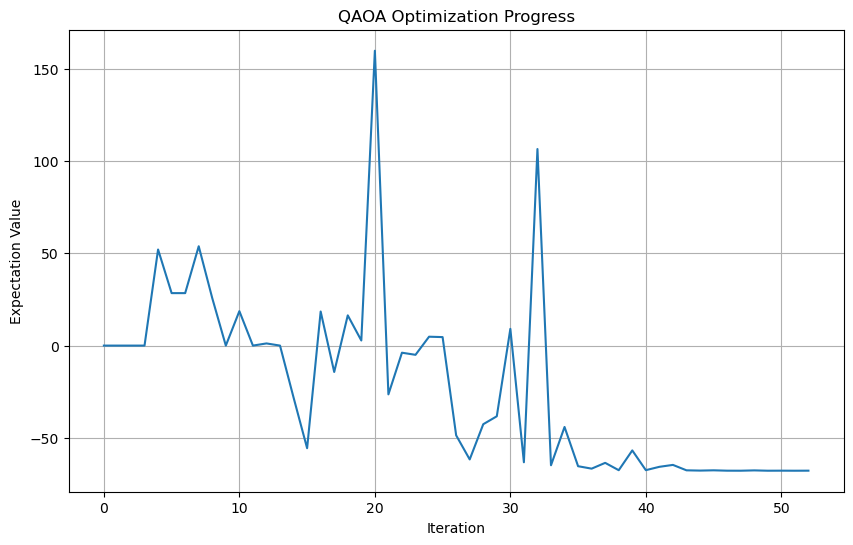

In [17]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

n_qubits = 11

layers = 3
init = np.random.uniform(0, 0, 2*layers)

initial= cudaq.sample(qaoa_kernel, init, n_qubits, layers,  # Sample results from initial state with all 0 parameters
                     h_list, pair_inds, J_list, shots_count=10000)

print(initial)


cost_history = []

def qaoa_cost(theta):
    res = cudaq.observe(qaoa_kernel, H, theta, n_qubits, layers,
                        h_list, pair_inds, J_list)
    cost = res.expectation()
    cost_history.append(cost)
    
    return cost

opt_result = minimize(qaoa_cost, init, method='COBYLA',
                      options={'maxiter': 200, 'disp': True})


print(opt_result)

shots = cudaq.sample(qaoa_kernel, opt_result.x, n_qubits, layers,
                     h_list, pair_inds, J_list, shots_count=10000)

print(shots)
print('Most-probable bit-string :', np.array(shots.most_probable()).astype(str))

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel("Expectation Value")
plt.title('QAOA Optimization Progress')
plt.grid(True)
plt.show()